<span style="font-size:200%; text-align:left;"><b>Lab setup of long SRC in a Michelson</b></span>
<br/>
Code : Mostly D.Toyra but I, V Adya chipped in


# Importing packages

In [1]:
import pykat
import pykat.ifo as ifo
import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot
from pykat.optics import ABCD as a

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

import pickle
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset']=False


from scipy.optimize import minimize
from pykat.optics.gaussian_beams import BeamParam

                                              ..-
    PyKat develop         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## The model

In [2]:
base = pykat.finesse.kat()
base.verbose = True
base.load("LongSRC_design_03Oct.kat")

base.removeBlock('Photodiodes')


## Run 0
Setting the phase of the BHD laser

--------------------------------------------------------------
Running kat - Started at 2019-10-07 19:46:38.355430

Finished in 0.0328581 seconds


100% | ETA:  0:00:00 | Saving data                                             

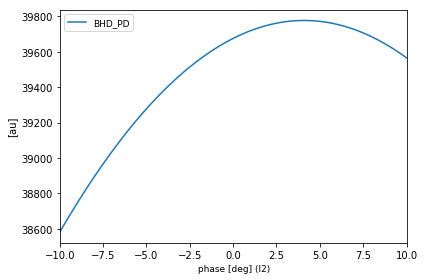

In [3]:
kat = base.deepcopy()
kat.cTSRM.remove()
kat.parse("""
hd BHD_PD 180 nOut1 nOut2

fsig darm LX phase 1.0 0.0 
fsig darm LY phase 1.0 180.0 

xaxis l2 phase lin -10 10 100
""")

out = kat.run()

out.plot()
phs_value = out.x[out['BHD_PD'].argmax()]

# Run 1 
Comparision of GW signal from arms to input


## GW signal from arms

--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:45:29.453437

Finished in 0.0830112 seconds


100% | ETA:  0:00:00 | Calculating                                             

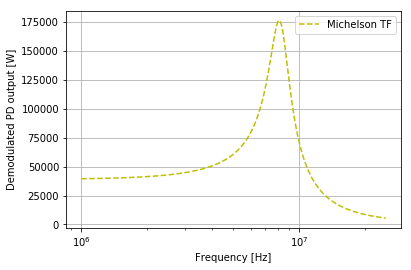

In [68]:
kat = base.deepcopy()

kat.l2.phase = phs_value

kat.parse("""
hd BHD_PD 180 nOut1 nOut2

fsig darm LX phase 1.0 0.0 
fsig darm LY phase 1.0 180.0 

xaxis darm f log 1M 25M 1000
yaxis abs:deg

""")
kat.maxtem = 'off'

out = kat.run()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.semilogx(out.x, np.abs(out['BHD_PD']), 'y--', label='Michelson TF')
ax.legend()
ax.set_ylabel('Demodulated PD output [W]')
ax.grid()
ax.set_xlabel('Frequency [Hz]')
plt.show(fig)

## GW signal from swept sine on modulator

--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:45:39.818642

Finished in 0.0474272 seconds


100% | ETA:  0:00:00 | Calculating                                             

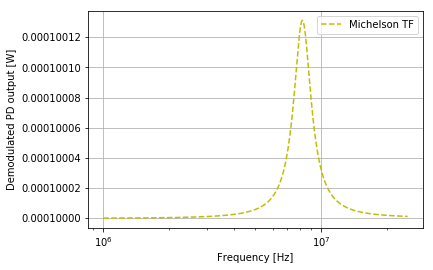

In [70]:
kat = base.deepcopy()
kat.l2.phase = phs_value

kat.parse(""" 
hd BHD_PD 0 nOut1 nOut2
xaxis eom1 f log 1M 25M 1000
yaxis abs:deg
""")
kat.maxtem = 'off'
kat.eom1.midx = 0.1

lschn = 5e-3
kat.LX.L = kat.LX.L - lschn
kat.LY.L = kat.LY.L + lschn

out = kat.run()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(out.x, np.abs(out['BHD_PD']), 'y--', label='Michelson TF')
ax.legend()
ax.set_ylabel('Demodulated PD output [W]')
ax.grid()
ax.set_xlabel('Frequency [Hz]')
plt.show(fig)

# Optimising the reflectivity of the compound mirror


## Sweeping schnupp asymmetry

--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:39:25.154469

Finished in 0.0554469 seconds
--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:39:25.212310

Finished in 0.048876 seconds
--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:39:25.263759

Finished in 0.0487046 seconds
--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:39:25.314795


100% | ETA:  0:00:00 | Calculating                                             


Finished in 0.0495369 seconds
--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:39:25.366881

Finished in 0.0530818 seconds
--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:39:25.423586

Finished in 0.048492 seconds
--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:39:25.474648

Finished in 0.0477309 seconds
--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:39:25.524585


100% | ETA:  0:00:00 | Calculating                                             


Finished in 0.0484762 seconds
--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:39:25.575164

Finished in 0.049973 seconds
--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:39:25.627418

Finished in 0.047756 seconds


100% | ETA:  0:00:00 | Calculating                                             

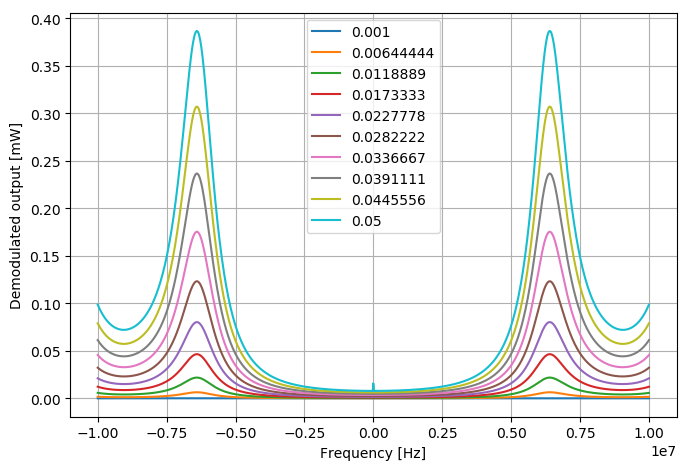

In [66]:
fig = plt.figure(figsize=(7,9), dpi=100)
ax1 = fig.add_subplot(211)

kat = base.deepcopy()
kat.parse("""
pd hej nTSRM2
xaxis Laser f lin -10M 10M 1000
yaxis abs:deg
""")
kat.maxtem = 'off'
kat.eom1.midx = 0.1

L = kat.lsr1.L.value + kat.lsr2.L.value + kat.lsr3.L.value
kat.lsr1.L = 0
kat.lsr2.L = 0
kat.lsr3.L = 0

kat.LX.L = kat.LX.L.value + L
kat.LY.L = kat.LY.L.value + L

arr = np.linspace(1e-3,5e-2,10)

for k,a in enumerate(arr):
    kat.LX.L = 2.2644 + (a/2)
    kat.LY.L = 2.2644 - (a/2)
    out = kat.run(cmd_args=["-cr=on"])
    ax1.plot(out.x,(out['hej'])*1e3,label="%g" %a)
       
plt.ylabel("Demodulated output [mW]")
plt.xlabel("Frequency [Hz]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.grid
#plt.savefig("InputPowers_Sensitivity.eps")
plt.show()
    


## Sweeping laser frequency

Parsing `variable schnupp_asym 0` into pykat object not implemented yet, added as extra line.

put command component `put* LX l $xlength` does not have a
parameter `l`


Parsing `put* LX l $xlength` into pykat object not implemented
yet, added as extra line.


put command component `put* LY l $ylength` does not have a
parameter `l`


Parsing `put* LY l $ylength` into pykat object not implemented
yet, added as extra line.

--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:34:10.046964

Finished in 0.027539 seconds
Best schnupp asymmetry =  0.45


100% | ETA:  0:00:00 | Saving data                                             

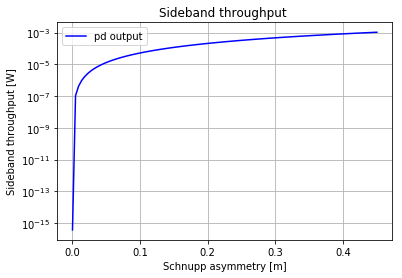

In [63]:
kat = base.deepcopy()

kat.l2.phase = phs_value
kat.maxtem = 'off'
kat.Laser.f = 4e6
kat.eom1.midx = 0

L = kat.lsr1.L.value + kat.lsr2.L.value + kat.lsr3.L.value
kat.lsr1.L = 0
kat.lsr2.L = 0
kat.lsr3.L = 0

kat.LX.L = kat.LX.L.value + L
kat.LY.L = kat.LY.L.value + L

kat.parse(""" 
pd hej nTSRM2

variable schnupp_asym 0
xaxis schnupp_asym re lin 0 45e-2 100

func xlength = 0.5*$x1
func ylength = (-0.5)*$x1

put* LX l $xlength
put* LY l $ylength
""")


out1=kat.run()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(out1.x,np.abs(out1['hej']),'b',label='pd output')
ax.legend()
ax.set_title('Sideband throughput ')
ax.set_yscale("log")
ax.set_xlabel('Schnupp asymmetry [m]')
ax.set_ylabel('Sideband throughput [W]')
ax.grid()

print('Best schnupp asymmetry = ', out1.x[out1['hej'].argmax()] )

# Radii of curvature optimisation

## Controller, constraints

In [64]:
RoC = [0.1,0.25,0.5,0.75,1,1.333,1.5,2,3,4,5,6.667,10]   # RoCs available off the shelf


RoC_EX = 5
RoC_EY = 5


w_crys = 30e-6

# Constraints
w_bs = 3.4e-3
w_etm = 4.8e-3
w_srm = 4.8e-3

## SRC cavity parameters and stability

In [65]:
kat = base.deepcopy()
kat.cTSRM.remove()
kat.parse("""
bp w_ex x w nEMx
bp w_ey x w nEMy
bp w_bs x w nBS4
bp w_srm x w nSRM1

cp cSRMX x m
cp cSRMY x m
cp cSRMX y m
cp cSRMY y m 

noxaxis
yaxis abs
trace 2
""")

kat.SRM.Rc = 5
out = kat.run()
print(out.stdout)
print()
print('      w      max_w')
print('EX:  {:.4f}   {} '.format(out['w_ex']*1e3, w_etm*1e3 ))
print('EY:  {:.4f}   {} '.format(out['w_ey']*1e3, w_etm*1e3 ))
print('BS:  {:.4f}   {} '.format(out['w_bs']*1e3, w_bs*1e3 ))
print('SRM: {:.4f}   {} '.format(out['w_srm']*1e3, w_srm*1e3 ))

print()

print('EX:  diff = {:.2f} mm, rdiff = {:.2} '.format((out['w_ex']-w_etm)*1e3, (out['w_ex']-w_etm)/np.abs(w_etm) ) )
print('EY:  diff = {:.2f} mm, rdiff = {:.2} '.format((out['w_ey']-w_etm)*1e3, (out['w_ey']-w_etm)/np.abs(w_etm) ) )
print('BS:  diff = {:.2f} mm, rdiff = {:.2} '.format((out['w_bs']-w_bs)*1e3, (out['w_bs']-w_bs)/np.abs(w_bs) ) )
print('SRM: diff = {:.2f} mm, rdiff = {:.2} '.format((out['w_srm']-w_srm)*1e3, (out['w_srm']-w_srm)/np.abs(w_srm) ) )
print()

# Checking stability
# --------------------
mX_x = np.abs(out['cSRMX_x_m'])
mY_x = np.abs(out['cSRMY_x_m'])
mX_y = np.abs(out['cSRMX_x_m'])
mY_y = np.abs(out['cSRMY_x_m'])

if (not (mX_x > -1 and mX_x < 1) or not (mX_y > -1 and mX_y < 1) or 
    not (mY_x > -1 and mY_x < 1) or not (mY_y > -1 and mY_y < 1)):
    print('Cavity is unstable!!!!! :(')
    print('Stability parameters: {}  {}  {}  {}'.format(mX_x, mY_x, mX_y, mY_y))
else:
    print('Cavity is stable! :) ')
    print('Stability parameters: {}  {}  {}  {}'.format(mX_x, mY_x, mX_y, mY_y))
# --------------------
  
    


--------------------------------------------------------------
Running kat - Started at 2019-10-07 21:37:00.422603

Finished in 0.02071 seconds

------------------------------------------------------------------------
                     FINESSE 2.2                (build 2.2-31-ge1141681)
       o_.-=.        Frequency domain INterferomEter Simulation SoftwarE
      (\'".\|        06.03.2019         http://www.gwoptics.org/finesse/
      .>' (_--.      
   _=/d   ,^\        Input file /var/folders/k1/yts33d_93v1_9yd1768nkwph0000gn/T/tmpurtcy_fz.kat,
  ~~ \)-'   '        Output file /var/folders/k1/yts33d_93v1_9yd1768nkwph0000gn/T/tmpurtcy_fz.out,
     / |             Gnuplot file /var/folders/k1/yts33d_93v1_9yd1768nkwph0000gn/T/tmpurtcy_fz.gnu 
    '  '                                        Mon Oct  7 21:37:00 2019
------------------------------------------------------------------------
 'noxaxis' has been set, ignoring all other xaxis commands
 --- cavity tracing
 cavity cSRMX:
  ca

100% | ETA:  0:00:00 | Calculating                                             

## TSRM RoCs and stability

In [ ]:
def q2w(q0,z,n=1):
    w = np.zeros(len(z))
    for k,a in enumerate(z):
        w[k] = BeamParam(q=q0+a, nr=n).w
    return w



###############################################
# Lengths and parameters
###############################################


# End mirror
w_ex = BeamParam(q=qex).w

# End mirror to BS
L_ex_bs = kat.LX.L.value
z_ex_bs = np.linspace(0,L_ex_bs,50)
w_ex_bs = q2w(qex, z_ex_bs)

# BS
w_bs = BeamParam(q=qbsx).w

# BS to SRM
L_bs_srm = kat.SRC1.L.value
z_bs_srm = np.linspace(0,L_bs_srm,50)
w_bs_srm = q2w(qbsx,z_bs_srm)
z_bs_srm += L_ex_bs

# SRM
w_srm = BeamParam(q=qsrm).w

# SRM substrate
L_srm_sub = kat.thsrm1.L.value

# SRM AR
w_srmar = BeamParam(q=qsrmarx).w

# SRM AR to Crystal
L_srm_crys = kat.SRCc2.L.value
z_srm_crys = np.linspace(0,L_srm_crys,50)
w_srm_crys = q2w(qsrmarx, z_srm_crys)
z_srm_crys += L_ex_bs+L_bs_srm+L_srm_sub

# Crystal, surface 1
w_crys = BeamParam(q=qcr1).w

# Inside the Crystal
L_crys = kat.sCRYS.L.value
z_crys_sub = np.linspace(0,L_crys,50)
w_crys_sub = q2w(qcr1*kat.sCRYS.n.value, z_crys_sub, n=kat.sCRYS.n.value)
z_crys_sub += L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys


# Crystal, surface 2
w_crys2 = BeamParam(q=qcr2).w

# Crystal to TSRM
L_crys_tsrm = kat.SRC2.L.value
z_crys_tsrm = np.linspace(0,L_crys_tsrm,50)
w_crys_tsrm = q2w(qcr2,z_crys_tsrm)
z_crys_tsrm += L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys

# TSRM
w_tsrm = BeamParam(q=qtsrm).w


###############################################
# Plotting
###############################################

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

# End mirror
ax.plot(0,w_ex*1e3,'b*')
ax.plot(0,-w_ex*1e3,'b*')

# End mirror to BS
ax.plot(z_ex_bs, w_ex_bs*1e3,'-b')
ax.plot(z_ex_bs, -w_ex_bs*1e3,'-b')

# BS
ax.plot(L_ex_bs, w_bs*1e3,'b*')
ax.plot(L_ex_bs, -w_bs*1e3,'b*')

# BS to SRM
ax.plot(z_bs_srm, w_bs_srm*1e3,'-b')
ax.plot(z_bs_srm, -w_bs_srm*1e3,'-b')

# SRM
ax.plot(L_ex_bs+L_bs_srm,w_srm*1e3,'b*')
ax.plot(L_ex_bs+L_bs_srm,-w_srm*1e3,'b*')

# SRMAR
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub,w_srmar*1e3,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub,-w_srmar*1e3,'b*')

# SRMAR to Crystal
ax.plot(z_srm_crys, w_srm_crys*1e3,'-b')
ax.plot(z_srm_crys, -w_srm_crys*1e3,'-b')

# Crystal surface 1
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, w_crys*1e3,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, -w_crys*1e3,'b*')

# Inside Crystal
ax.plot(z_crys_sub, w_crys_sub*1e3,'-b')
ax.plot(z_crys_sub, -w_crys_sub*1e3,'-b')

# Crystal surface 2
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, w_crys2*1e3,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, -w_crys2*1e3,'b*')

# Crystal to TSRM
ax.plot(z_crys_tsrm, w_crys_tsrm*1e3,'-b')
ax.plot(z_crys_tsrm, -w_crys_tsrm*1e3,'-b')

# TSRM
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys+L_crys_tsrm, w_tsrm*1e3,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys+L_crys_tsrm, -w_tsrm*1e3,'b*')

ax.set_ylabel('w [m]')
ax.set_xlabel('z [m]')

ax.grid()
ax.set_ylabel('Beam radius [mm]')
ax.set_title('EX-BS-SRM-TSRM cavities')
#plt.savefig('Beam_Evolution.png')
plt.show(fig)

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

# Crystal surface 1
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, w_crys*1e6,'b*')
#ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, -w_crys*1e6,'b*')

# Inside Crystal
ax.plot(z_crys_sub, w_crys_sub*1e6,'-b')
#ax.plot(z_crys_sub, -w_crys_sub*1e6,'-b')

# Crystal surface 2
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, w_crys2*1e6,'b*')
#ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, -w_crys2*1e6,'b*')
ax.grid()
ax.set_ylabel('Beam radius [um]')
ax.set_title('Inside crystal')
#plt.savefig('Beam_Evolution_zoomed.png')
plt.show(fig)